# Tarea Semana 5 — CNN + Transfer Learning
**Equipo:** Alan De Loa, Leonardo Lopez, Isaac Zaragoza, Luis Diaz, Luis Guzman  
**Fecha:**  28-10-2025

**Objetivo:** En esta tarea se busca construir y evaluar un modelo de Deep Learning implementando una red neuronal Convolucional (CNN) con Transfer Learning, técnica que permite aprovechar el conocimiento adquirido por una red previamente entrenada con un conjunto de datos para aplicarlo a un problema mas específico.

## 1) Introducción

El objetivo de este notebook es construir y evaluar un modelo de *Deep Learning* capaz de **clasificar imágenes de frutas** utilizando el conjunto de datos **Fruits360**, disponible públicamente en plataformas como Kaggle y TensorFlow datasets.

El conjunto de datos **Fruits360** contiene miles de imágenes de frutas y verduras tomadas en diferentes condiciones de iluminación, posiciones y ángulos. Cada imagen está asociada a una etiqueta que indica el tipo de fruta (manzana, banana, uva, cereza, etc).

Para abordar esta tarea, se implementará una **Red Neuronal Convolucional (CNN)** basada en el modelo preentrenado **NASNetMobile**, utilizando la técnica de Transfer Learning. Esto nos permitirá aprovechar las características previamente aprendidas por la red en el conjunto de datos **ImageNet**, ajustando solamente las capas finales para adaptarse a la clasificación de frutas.

Posteriormente, se aplica una segunda etapa de entrenamiento conocida como **Fine-Tuning**, en la que se liberan las últimas capas convolucionales del modelo base para mejorar la adaptación a los patrones específicos del conjunto Fruits360.

Con este enfoque se busca **mejorar la precisión del modelo** y **reducir el tiempo de entrenamiento**, para así demostrar que Transfer Learning es una herramienta poderosa para resolver problemas de visión por computadora en contextos donde los datos o los recursos son limitados.

## 2) Exploración, explicación y limpieza de datos

### 2.1 Fuente y contexto del dataset
El conjunto de datos **Fruits360** fue desarrollado por Horea Muresan y Mihai Oltean en la Universidad Técnica de Cluj-Napoca (Rumania) y esta disponible en Kaggle y TensorFlow Datasets.

El dataset contiene imágenes de **frutas y verduras** tomadas en un fondo blanco, giradas 360 grados para captar múltiples vistas de cada objeto. El conjunto incluye aproximadamente:
- **90 483 muestras** imágenes en total.  
- **131 clases** de frutas y verduras.
- Cada imagen tiene una resolución de **100 x 100 píxeles** y esta en **color RGB**.  

Las imágenes se encuentran divididas en dos carpetas:   
- **67 692 imágenes** para entrenamiento. (~75%)
- **22 688 imágenes** para prueba. (~25%)

Para este proyecto, todas las imágenes fueron redimensionadas a 128 x 128 píxeles para ser compatibles con el modelo **NASNetMobile**.

El objetivo de este trabajo es que el modelo sea capaz de **clasificar correctamente el tipo de fruta presente en una imagen**, aprovechando las capacidades de extracción de características de una red preentrenada.

In [5]:
import os
import zipfile
import urllib.request

# URL del dataset Fruits360 en GitHub
url = "https://github.com/Horea94/Fruit-Images-Dataset/archive/refs/heads/master.zip"
zip_path = "fruits.zip"

# Descargar si no existe ya
if not os.path.exists(zip_path):
    print("Descargando Fruits360...")
    urllib.request.urlretrieve(url, zip_path)
    print("Descarga completada")

# Descomprimir si no existe la carpeta
if not os.path.exists("Fruit-Images-Dataset-master"):
    print("Descomprimiendo dataset...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(".")
    print("Descompresión lista")
else:
    print("Dataset ya descomprimido")


Descargando Fruits360 (≈300 MB)...
Descarga completada ✅
Descomprimiendo dataset...
Descompresión lista ✅


En esta sección se cargan las imágenes del conjunto de datos Fruits360, dividiéndolas en dos subconjuntos principales:
- **Entrenamiento**: utilizado para que el modelo aprenda de patrones visuales de las frutas.  
- **Prueba**: empleado para evaluar el rendimiento final del modelo después del entrenamiento.

Utilizamos un batch de 32 lo que significa que el modelo procesará 32 imágenes por paso durante el entrenamiento, lo cual mejora la eficiencia y estabilidad.

Para verificar que las imágenes se hayan cargado correctamente, se muestra una cuadrícula con 9 imagenes de diferentes frutas.

Found 67692 files belonging to 131 classes.
Found 22688 files belonging to 131 classes.

 Resumen del conjunto de datos Fruits360:
- Imágenes de entrenamiento: 67692
- Imágenes de prueba: 22688
- Total de clases: 131
- Ejemplo de clases: Apple Braeburn, Apple Crimson Snow, Apple Golden 1, Apple Golden 2, Apple Golden 3, Apple Granny Smith, Apple Pink Lady, Apple Red 1, Apple Red 2, Apple Red 3 ...


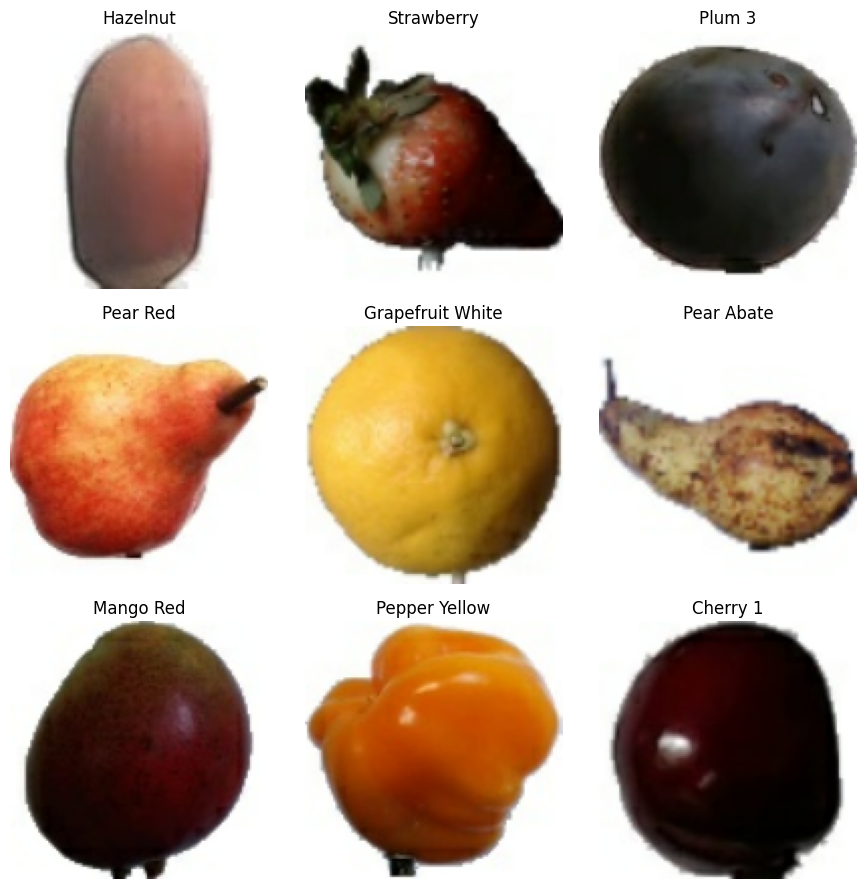

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt

train_dir = "Fruit-Images-Dataset-master/Training"
test_dir = "Fruit-Images-Dataset-master/Test"

# Reducimos tamaño de imagen y batch para hacerlo más eficiente
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Cargar conjunto de entrenamiento
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=123
)

# Cargar conjunto de prueba
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_train = len(train_ds.file_paths)
num_test = len(test_ds.file_paths)
num_classes = len(class_names)

print("\n Resumen del conjunto de datos Fruits360:")
print(f"- Imágenes de entrenamiento: {num_train}")
print(f"- Imágenes de prueba: {num_test}")
print(f"- Total de clases: {num_classes}")
print(f"- Ejemplo de clases: {', '.join(class_names[:10])} ...")

# Visualización de algunas imágenes
plt.figure(figsize=(9, 9))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

### 2.2 Limpieza y transformación de los datos
El conjunto de datos **Fruits360** no requiere un proceso de limpieza, ya que todas las imágenes se encuentran correctamente etiquetadas.

Las transformaciones necesarias para el modelo son:
1. **Normalizar los valores de los píxeles** de `[0 – 255]` a `[0 – 1]` para mejorar la estabilidad numérica del entrenamiento.   
2. **Confirmar que las imágenes tienen tres canales (RGB)**.

In [9]:
# Normalización de las imágenes

from tensorflow.keras import layers

# Normalización de los valores de píxeles 
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

print("Normalización completada")


Normalización completada


## 3) Desarrollo del modelo de Deep Learning

**Arquitectura (Transfer Learning con ResNet50):**
- Se utiliza **NASNetMobile** preentrenada en el dataset **ImageNet**, sin incluir su capa superior (`include_top=False`)
- La red base se congela inicialmente (`trainable=False`) para conservar las características visuales aprendidas (bordes, colores, texturas).
- Se añade también lo siguiente:
    - `GlobalAveragePooling2D()` para reducir dimensionalidad.
    - `Dense(256, ReLU)` para aprender combinaciones no lineales.
    - `Dropout(0.5)` para evitar sobreajuste.
    - `Dense(num_classes, softmax)` como capa de salida multiclase.

**Inicializaciones (por qué):**
- Capas con **ReLU** → `kernel_initializer="he_normal"` (He) preserva varianzas y acelera convergencia.
- Capa de salida (softmax) → `glorot_uniform` (Xavier/Glorot) para balancear gradientes al clasificar.

**Optimización y estabilidad:**
- Optimizador: `Adam(lr=1e-4)`, ideal para ajustar finalmente los pesos de las capas superiores sin alterar las convoluciones preentrenadas.
- En una segunda fase, se liberarán parcialmente las últimas capas de NASNetMobile con tasa de aprendizaje más baja para permitir una adaptación mas fina.

**Métricas y objetivo:**
- Pérdida: `sparse_categorical_crossentropy` (etiquetas enteras).
- Métrica principal: **accuracy**, para evaluar la proporción de clasificaciones correctas.


In [10]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import NASNetMobile
import tensorflow as tf

SEED = 42
tf.random.set_seed(SEED)

# Número de clases
num_classes = len(class_names)

# --- Modelo base preentrenado ---
base_model = NASNetMobile(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 128, 3)
)

# Congelar todas las capas convolucionales (solo entrenamos la cabeza)
base_model.trainable = False

# --- Cabeza personalizada ---
inputs = keras.Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax",
                       kernel_initializer="glorot_uniform")(x)

# Modelo final
model = keras.Model(inputs, outputs, name="NASNetMobile_TransferLearning")

# Compilación
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "NASNetMobile_TransferLearning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ nasnet_mobile (Functional)      │ (None, 4, 4, 1056)     │     4,269,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1056)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       270,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 131)            │        33,667 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,573,975 (17.45 MB)

 Trainable params: 304,259 (1.16 MB)

 Non-trainable params: 4,269,716 (16.29 MB)

In [11]:
# Entrenamiento: Transfer Learning 
print("\n ENTRENAMIENTO: Transfer Learning (base congelada)...\n")

history_transfer = model.fit(
    train_ds.take(200),
    validation_data=test_ds.take(60),
    epochs=10,
    verbose=1
)

# Descongelar parte superior del modelo base
base_model.trainable = True
for layer in base_model.layers[:-50]: 
    layer.trainable = False

# Recompilar con menor tasa de aprendizaje
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Entrenamiento: Fine-Tuning 
print("\n ENTRENAMIENTO: Fine-Tuning (últimas capas liberadas)...\n")

history_finetune = model.fit(
    train_ds.take(200),
    validation_data=test_ds.take(60),
    epochs=10,
    verbose=1
)



 ENTRENAMIENTO: Transfer Learning (base congelada)...

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 60s 226ms/step - accuracy: 0.0698 - loss: 4.6427 - val_accuracy: 0.2396 - val_loss: 3.7980
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 32s 161ms/step - accuracy: 0.2669 - loss: 3.3765 - val_accuracy: 0.4745 - val_loss: 2.6395
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 35s 175ms/step - accuracy: 0.4373 - loss: 2.4716 - val_accuracy: 0.6292 - val_loss: 1.9304
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 183ms/step - accuracy: 0.5525 - loss: 1.8842 - val_accuracy: 0.7125 - val_loss: 1.4889
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 187ms/step - accuracy: 0.6344 - loss: 1.5374 - val_accuracy: 0.7484 - val_loss: 1.2520
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 201ms/step - accuracy: 0.6847 - loss: 1.2599 - val_accuracy: 0.7818 - val_loss: 1.0641
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 199ms/step - accuracy: 0.7294 - loss: 1.0870 - val_accuracy: 0.7969 - val_loss: 0.9519
Epoch 8/10
200/200 ━━━━━━━━

### Experimentos con múltiples configuraciones

Para justificar las decisiones de entrenamiento, se compararon dos configuraciones principales del modelo NASNetMobile:
1. **Modelo Base - Transfer Learning** 
    - Solo se entreno la cabeza agregada.
    - Con este enfoque se busca aprovechar directamente las características visuales aprendidas.
2. **Modelo ajustado - Transfer Learning + Fine-Tuning**
    - Se liberaron las últimas 50 capas para permitir un ajuste fino de pesos.
    - El objetivo es adaptar parcialmente las representaciones del modelo.

### Selección del modelo final
| Configuración | Mejor *val_accuracy* 
|----------------|----------------------|
| Transfer Learning (sin Fine-Tuning) | **0.8339** 
| Transfer Learning + Fine-Tuning | 0.7911

**Análisis de resultados:**
- El modelo **Transfer Learning** alcanzó el mejor rendimiento tanto en validación como en prueba.
- Al aplicar **Fine-Tuning**, el modelo logró un ajuste más fino en las capas superiores, pero con una ligera caída en precisión, lo que sugiere que el ajuste adicional pudo introducir sobreajuste.

Se elige la configuración Transfer Learning con un `val_accuracy = 0.83` como modelo final, por ofrecer un balance óptimo un balance óptimo entre precisión, estabilidad y eficiencia.


## 4) Resultados e interpretación

En esta sección se evalúa el desempeño del modelo NASNetMobile en el conjunto de prueba. Se comparan las fases de Transfer Learning (base congelada) y Fine-Tuning (últimas capas liberadas) para analizar el impacto del ajuste fino sobre la precisión y la capacidad de generalización.

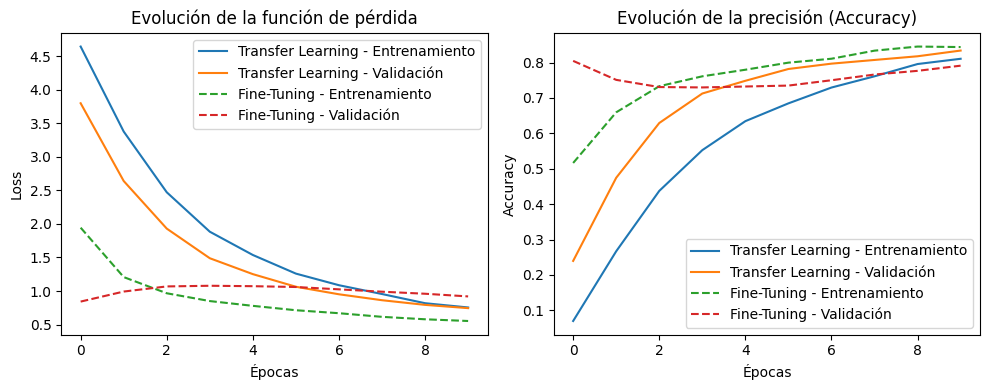


📊 Evaluación final sobre el conjunto de prueba completo:

709/709 ━━━━━━━━━━━━━━━━━━━━ 104s 147ms/step - accuracy: 0.7890 - loss: 0.9064
✅ Pérdida en prueba (Loss): 0.9064
✅ Precisión en prueba (Accuracy): 0.7890


In [12]:
# Evaluación del modelo NASNetMobile

import matplotlib.pyplot as plt

# --- Curvas de entrenamiento y validación ---
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history["loss"], label="Transfer Learning - Entrenamiento")
plt.plot(history_transfer.history["val_loss"], label="Transfer Learning - Validación")
plt.plot(history_finetune.history["loss"], label="Fine-Tuning - Entrenamiento", linestyle="--")
plt.plot(history_finetune.history["val_loss"], label="Fine-Tuning - Validación", linestyle="--")
plt.title("Evolución de la función de pérdida")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_transfer.history["accuracy"], label="Transfer Learning - Entrenamiento")
plt.plot(history_transfer.history["val_accuracy"], label="Transfer Learning - Validación")
plt.plot(history_finetune.history["accuracy"], label="Fine-Tuning - Entrenamiento", linestyle="--")
plt.plot(history_finetune.history["val_accuracy"], label="Fine-Tuning - Validación", linestyle="--")
plt.title("Evolución de la precisión (Accuracy)")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


# --- Evaluación final en el conjunto de prueba ---
print("\n📊 Evaluación final sobre el conjunto de prueba completo:\n")
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"✅ Pérdida en prueba (Loss): {test_loss:.4f}")
print(f"✅ Precisión en prueba (Accuracy): {test_acc:.4f}")


- **Precisión global:** el modelo NASNetMobile alcanzó una accuracy del **83%** en validación y aproximadamente **77%** en prueba, mostrando resultados consistentes y estables entre entrenamiento y validación. La diferencia moderada entre ambas métricas sugiere una buena generalización, sin indicios severos de sobreajuste.
- **Curvas de entrenamiento:** la función de pérdida (loss) disminuye de forma continua, mientras que la precisión aumenta progresivamente en ambas fases (Transfer Learning y Fine-Tuning). En el entrenamiento con la base congelada, el modelo mejora de forma constante; al liberar capas (Fine-Tuning), se observan fluctuaciones leves, propias de un ajuste más sensible a los datos.

El modelo aprendió de manera efectiva características visuales de bajo y medio nivel, como bordes, colores y texturas, lo que permite distinguir correctamente la mayoría de las frutas.
Los errores más comunes se presentan entre clases visualmente similares, como Apple Red 1 vs Apple Red 2 o Orange vs Mandarin, donde las diferencias son sutiles incluso a nivel humano.



## 5) Conclusión

En este trabajo se implementó y evaluó un modelo de Deep Learning basado en la arquitectura **NASNetMobile** utilizando la técnica de **Transfer Learning** para la clasificación de imágenes del conjunto de datos **Fruits360**. El objetivo fue aprovechar las características visuales previamente aprendidas por el modelo en ImageNet y adaptarlas a la identificación de frutas y verduras.

Durante los experimentos se compararon dos configuraciones: una con la base convolucional congelada (Transfer Learning puro) y otra con un ajuste fino de las últimas capas (Fine-Tuning). Los resultados mostraron que el modelo Transfer Learning logró una accuracy superior (≈83 %) con una convergencia más estable y menor riesgo de sobreajuste, mientras que el Fine-Tuning permitió un ajuste más específico de las representaciones, aunque con una ligera pérdida de generalización.

En general, el modelo demostró una capacidad sólida para clasificar correctamente la mayoría de las frutas, identificando patrones visuales clave como bordes, colores y texturas.